<h1>Analysis of Airbnb data for Seatleo</h1>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
import matplotlib.pyplot as plt
# helper functions in another file
from functions import *
# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline


<h2>Gathering data</h2>
<h3>Calendar table</h3>
It includes listing id and the price and availability for that day.
A price in USD us set only when the place is available, else NaN is used

In [2]:
cal = pd.read_csv('./data-seattle/calendar.csv')
cal.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [3]:
convert_date_cols(cal,['date'])
convert_price_cols(cal, ['price'])
convert_bool_cols(cal,['available'],{'t':1,'f':0})
cal_prices = cal.dropna(subset=['price'],axis=0)
cal_prices.head()

,listing_id,date,available,price
0,241032,2016-01-04,1,85.0
1,241032,2016-01-05,1,85.0
9,241032,2016-01-13,1,85.0
10,241032,2016-01-14,1,85.0
14,241032,2016-01-18,1,85.0


<h3>Reviews table</h3>
It includes unique id for each reviewer and detailed comments. We will not be using this table

In [4]:
reviews = pd.read_csv('./data-seattle/reviews.csv')
print(reviews.dtypes)

listing_id        int64
id                int64
date             object
reviewer_id       int64
reviewer_name    object
comments         object
dtype: object


<h3>Listing table</h3>
It includes full descriptions and average review score

In [5]:
listing = pd.read_csv('./data-seattle/listings.csv')
num_cols,bool_cols,date_cols,cat_cols = get_df_by_types(listing,"before preprocess")

before preprocess:
	- 30 numeric columns
	- 0 boolean columns
	- 0 date columns
	- 62 categorical columns


<u> Preprocess listing table </u>

In [6]:
# Here we preprocess some columns to get scaled numerical values
# We do all replacements in place

# First we use pandas inference algorithm as initial guess
listing = listing.convert_dtypes()

# Prices are converted to float ($1,200.00 becomes 1200.00 )
price_cols = ['price',
       'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee',
       'extra_people']
convert_price_cols(listing, price_cols)

# Percentages (95%) are converted to [0;1]
percent_cols = ['host_response_rate', 'host_acceptance_rate']
convert_percent(listing, percent_cols)

# Columns 't'/'f' are converted to 1/0
bool_cols = ['is_location_exact','has_availability',"requires_license",'instant_bookable','require_guest_profile_picture',
            'require_guest_phone_verification','host_has_profile_pic','host_is_superhost','host_identity_verified']    
convert_bool_cols(listing, bool_cols)

# date strings are converted to datetime
date_cols = ['first_review','last_review','calendar_last_scraped',"last_scraped"]
convert_date_cols(listing, date_cols)

# finally scores are rescaled to [0;1]
convert_scores(listing,{'review_scores_accuracy':     10,
                        'review_scores_location':     10,
                        'review_scores_communication':10,
                        'review_scores_cleanliness':  10,
                        'review_scores_checkin':      10,
                        'review_scores_value':        10,
                        'review_scores_rating':       100})

# We drop columns with only NA values
listing.dropna(axis=1, how='all',inplace=True)

# We retrieve columns by types
num_cols,bool_cols,date_cols,cat_cols = get_df_by_types(listing,"after simple preprocess",False)

# Checking boolean conversion
listing['host_is_superhost'].head()

after simple preprocess:
	- 46 numeric columns
	- 0 boolean columns
	- 4 date columns
	- 41 categorical columns


0    0
1    1
2    0
3    0
4    0
Name: host_is_superhost, dtype: Int64

In [7]:
# Categories of interest:
category_for_dummies = ['cancellation_policy','property_type','room_type','bed_type']
for cat in category_for_dummies:
    print("There are {} NaN values in column {}. Possible values are {}".format(listing[cat].isna().sum(),
                                                                            cat,
                                                                           set(listing[cat].values)))


listing_dummies = create_dummy_df(listing, list(bool_cols.values) + category_for_dummies, False)
num_cols,bool_cols,date_cols,cat_cols = get_df_by_types(listing_dummies,"After dummies",False)


There are 0 NaN values in column cancellation_policy. Possible values are {'strict', 'flexible', 'moderate'}
There are 1 NaN values in column property_type. Possible values are {'Apartment', 'Bed & Breakfast', 'Dorm', <NA>, 'House', 'Condominium', 'Yurt', 'Chalet', 'Camper/RV', 'Tent', 'Boat', 'Bungalow', 'Other', 'Cabin', 'Townhouse', 'Loft', 'Treehouse'}
There are 0 NaN values in column room_type. Possible values are {'Entire home/apt', 'Private room', 'Shared room'}
There are 0 NaN values in column bed_type. Possible values are {'Couch', 'Real Bed', 'Futon', 'Pull-out Sofa', 'Airbed'}
Error when concatening column property_type
After dummies:
	- 54 numeric columns
	- 0 boolean columns
	- 4 date columns
	- 38 categorical columns


In [8]:
print("After preprocess, the following columns are numeric:")
print(list(num_cols))

After preprocess, the following columns are numeric:
['id', 'scrape_id', 'host_id', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_listings_count', 'host_total_listings_count', 'host_has_profile_pic', 'host_identity_verified', 'latitude', 'longitude', 'is_location_exact', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'square_feet', 'price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'requires_license', 'instant_bookable', 'require_guest_profile_picture', 'require_guest_phone_verification', 'calculated_host_listings_count', 'reviews_per_month', 'cancellation_policy_m

<u> Handling NaN values </u>


In [9]:
#Numeric columns with NA values
NA_frac = listing_dummies[num_cols].isnull().mean()
cond = NA_frac>0
cols_with_na = set(listing_dummies[num_cols].columns[cond])

print("There are {} numeric columns with NA values".format(len(cols_with_na)))

# Filling cols with mean or mode (booleans encoded as 0/1)
for col in cols_with_na:
    try:
        print("{} of type {} filled with mean = {}".format(col,listing_dummies[col].dtype,listing_dummies[col].mean()))
        listing_dummies[col].fillna(listing_dummies[col].mean(),inplace=True)
    except: 
        print("{} of type {} filled with mode = {}".format(col,listing_dummies[col].dtype,listing_dummies[col].mode()[0]))
        listing_dummies[col].fillna(listing_dummies[col].mode()[0],inplace=True)

listing_dummies.infer_objects()

# Check no NA remains
NA_frac = listing_dummies.isnull().mean()
cols_with_na = set(listing_dummies.columns[NA_frac>0])
if(len(cols_with_na)>0):
    print("NA values remain for the following columns: ")
    print('\n* '.join([""]+list(cols_with_na)[1:]))
else:
    print("All NA values were properly removed")


There are 23 numeric columns with NA values
bedrooms of type Int64 filled with mean = 1.3077124868835257
bedrooms of type Int64 filled with mode = 1
review_scores_location of type float64 filled with mean = 0.9608915586468696
weekly_price of type float64 filled with mean = 788.4818317570931
review_scores_cleanliness of type float64 filled with mean = 0.9556398104265547
host_acceptance_rate of type float64 filled with mean = 0.999671592775041
host_total_listings_count of type Int64 filled with mean = 7.1577568134171905
host_total_listings_count of type Int64 filled with mode = 1
cleaning_fee of type float64 filled with mean = 61.71090387374462
review_scores_value of type float64 filled with mean = 0.9452245414294961
monthly_price of type float64 filled with mean = 2613.336189848385
host_has_profile_pic of type Int64 filled with mean = 0.9981656184486373
host_has_profile_pic of type Int64 filled with mode = 1
review_scores_checkin of type float64 filled with mean = 0.9786708860759566
sec

<h2> What are the best locations </h2>
In this section, we look at highly scored places

There are 3818 accomodations on AirBnB
Average price is 119.84 USD


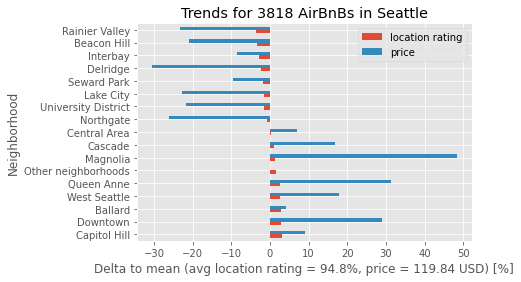

In [10]:
#'review_scores_rating','review_scores_value',
reviews_per_neighborhood = listing_dummies[['neighbourhood_group_cleansed','review_scores_location']]
count_vals = reviews_per_neighborhood.neighbourhood_group_cleansed.value_counts()

all_airbnb = count_vals.sum()
print("There are {} accomodations on AirBnB".format(all_airbnb))
count_vals_scaled = count_vals/all_airbnb*100

scores_by_loc = reviews_per_neighborhood.groupby('neighbourhood_group_cleansed').mean().sort_values(by='review_scores_location',ascending=False)


mean_location_rating = scores_by_loc.mean().review_scores_location

scores_by_loc_scaled = (scores_by_loc-mean_location_rating)/mean_location_rating*100
price_per_neighborhood = listing_dummies[['neighbourhood_group_cleansed','price']].groupby('neighbourhood_group_cleansed').mean()
price_per_neighborhood = price_per_neighborhood.sort_values(by='price',ascending=False)


avg_price = price_per_neighborhood.price.mean()
price_per_neighborhood_scaled = (price_per_neighborhood -avg_price)/avg_price*100

print("Average price is {:.2f} USD".format(avg_price))

plt.style.use('ggplot')

df = pd.DataFrame()
df['location rating'] = scores_by_loc_scaled.review_scores_location
df['price'] = price_per_neighborhood_scaled.price
df.plot.barh()
plt.title('Trends for {} AirBnBs in Seattle'.format(all_airbnb))
plt.ylabel('Neighborhood')
plt.xlabel("Delta to mean (avg location rating = {:.1f}%, price = {:.2f} USD) [%]".format(mean_location_rating*100, avg_price))
plt.show()


 <h2> What is the best time </h2>
    

<AxesSubplot:xlabel='date', ylabel='Average T [degC]'>

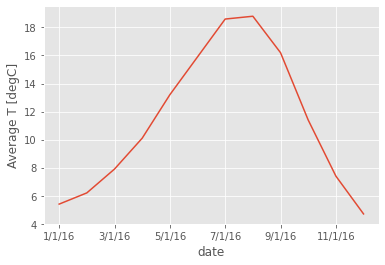

In [11]:
climate = pd.read_csv('./data-seattle/climate.csv',sep=";")
climate.index=climate.date
climate["Tavg"].plot(ylabel='Average T [degC]')

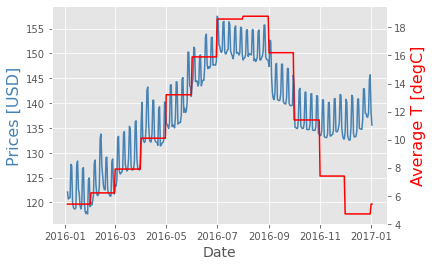

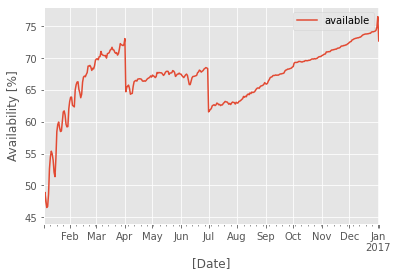

In [16]:
price_evo = cal[['date','price']].groupby(cal.date).mean()
price_evo['average_temp'] =  climate.Tavg
climate.date = climate.date.astype('datetime64')
climate.index = climate.date

new_month = False
current_month = 1
start_month_date = pd.Timestamp(year=2016,month=current_month,day=1)
Tavg = climate.loc[start_month_date].Tavg 
for t in price_evo.index: 
    if t.month!=current_month:
        
        current_month=t.month
        start_month_date = pd.Timestamp(year=2016,month=current_month,day=1)
        Tavg = climate.loc[start_month_date].Tavg
    price_evo.average_temp[t] = Tavg

#define subplots
fig,ax = plt.subplots()

#add first line to plot
ax.plot(price_evo.index, price_evo.price, color='steelblue')

#add x-axis label
ax.set_xlabel('Date', fontsize=14)

#add y-axis label
ax.set_ylabel('Prices [USD]', color='steelblue', fontsize=16)

#define second y-axis that shares x-axis with current plot
ax2 = ax.twinx()

#add second line to plot
ax2.plot(price_evo.index, price_evo.average_temp, color='red')

#add second y-axis label
ax2.set_ylabel('Average T [degC]', color='red', fontsize=16)
plt.grid(False)
plt.show()

avail_evo = cal[['date','available']].groupby(cal.date).mean()*100.0 
avail_evo.plot(ylabel = 'Availability [%]', xlabel=['Date'])

rooms_on_market = cal[['date','listing_id']].groupby(cal.date)


<h2> Does kindness pay? </h2>
In this section, we gonna investigate if flexible cancellation policy and good communication increase the revenue of hosts.

After feature selection:
	- 7 numeric columns
	- 0 boolean columns
	- 0 date columns
	- 0 categorical columns


,cancellation_policy_strict,cancellation_policy_moderate,require_guest_profile_picture,host_is_superhost,host_response_rate,review_scores_rating,price
2634,1,0,1,0,1.000000,0.90,325.0
3327,0,1,0,0,0.948868,1.00,88.0
3415,0,1,1,1,1.000000,0.97,55.0
2929,1,0,0,0,0.948868,0.91,152.0
3425,1,0,0,1,1.000000,0.91,62.0


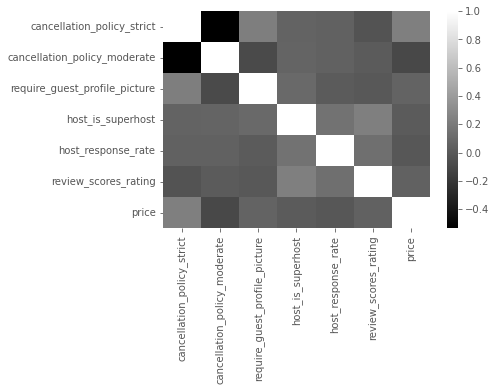

In [13]:
all_vars = ['cancellation_policy_strict', 'cancellation_policy_moderate','require_guest_profile_picture',
                         'host_response_rate','host_acceptance_rate','host_is_superhost','instant_bookable',
                         'review_scores_communication','review_scores_location','review_scores_value',
                         'review_scores_cleanliness','review_scores_checkin','review_scores_rating','reviews_per_month','price']

sub_vars = ['cancellation_policy_strict','cancellation_policy_moderate',
            'require_guest_profile_picture',
            'host_is_superhost','host_response_rate','review_scores_rating','price']

X_raw = listing_dummies[sub_vars]
num_cols,bool_cols,date_cols,cat_cols = get_df_by_types(X_raw,"After feature selection",False)

sns.heatmap(X_raw.corr(), cmap="gray")

X_raw.take(np.random.permutation(len(X_raw))[:5])

In [15]:

#Split into train and test
pred_var = 'review_scores_rating'

y = X_raw[pred_var]

X=X_raw.drop(pred_var,axis=1)
print("Trying to predict {} based on {} regressors and {} observations".format(pred_var,len(X.columns),X.shape[0]))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_test_preds = lm_model.predict(X_test) 
print("The r-squared score for the model using only quantitative variables was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test)))

Trying to predict review_scores_rating based on 6 regressors and 3818 observations
The r-squared score for the model using only quantitative variables was 0.042295044863974174 on 1146 values.
